# Cell segmentation & classification with Random Forest Classifier (RFC)

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Zzg5JlDGsvFSakiDLwnNc27HeVaLyu1V?usp=sharing)

**Content**  
1. *Cell segmentation*: Given a sparse user annotation of a single cell image, we can segment cells from the background using a pixel-wise Random Forest Classifier (RFC)  
2. *Cell classification*: Given a separated cell image and some sparse ground truth annotation we can classify cell objects based on size and shape measurements, e.g. derived using scikit-image `regionprops`. We will do this using a RFC as well.  

**Methodology**:
- This notebook has gaps that you have to fill. If all gaps are filled in correctly, the notebook can be run.
- A solution notebook with all gaps filled is provided in the GitHub repository.
- Gaps are marked with a `#TODO`

**Source, Inspiration**:  
This notebook is inspired by [Pixel Classification with Random Forest](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20a_pixel_classification/scikit_learn_random_forest_pixel_classifier.html) and [Object Classification with Random Forest](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/27_cell_classification/sklearn_object_classification.html).

## 1. Imports and Data
We will use the following libraries and methods:

- `os`: For interacting with the operating system.
- `RandomForestClassifier` from `sklearn.ensemble`: The implementation of the RFC by scikit-learn.
- `io`, `filters` and `measure` from `skimage`: Read and write images, filters and other functionability.
- `numpy` (`np`): For numerical operations.
- `pandas` (`pd`): For tabular data manipulation and visualization.
- `matplotlib.pyplot` (`plt`): For data visualization.

In [1]:
import os
from sklearn.ensemble import RandomForestClassifier
from skimage import io, filters, measure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We download all files that are not available (In the colab) from the internet (from the online GitHub repository of this workshop) and save them in the current workspace.

In [2]:
import urllib.request  # helper library to download files

if not os.path.exists('data/blobs.tif'):
    os.makedirs('data', exist_ok=True)
    urllib.request.urlretrieve('https://github.com/moritzmarquardt/workshop_IBEC/raw/refs/heads/main/data/blobs.tif', 'data/blobs.tif')
    print('Loaded and saved image from remote file')

if not os.path.exists('data/blobs_segmentation_annotation.npy'):
    os.makedirs('data', exist_ok=True)
    urllib.request.urlretrieve('https://github.com/moritzmarquardt/workshop_IBEC/raw/refs/heads/main/data/blobs_segmentation_annotation.npy', 'data/blobs_segmentation_annotation.npy') 
    print('Loaded and saved annotations from remote file')


if not os.path.exists('data/blobs_classification_annotation.npy'):
    os.makedirs('data', exist_ok=True)
    urllib.request.urlretrieve('https://github.com/moritzmarquardt/workshop_IBEC/raw/refs/heads/main/data/blobs_classification_annotation.npy', 'data/blobs_classification_annotation.npy') 
    print('Loaded and saved class annotations from remote file')


Image shape: (254, 256)
Image type: uint8
Image max: 248
Image min: 8


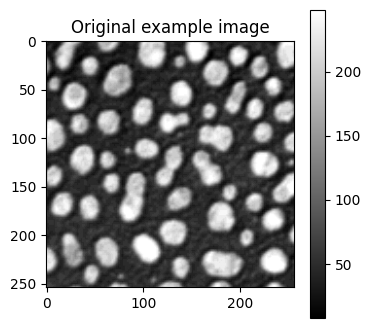

In [3]:
image = io.imread('data/blobs.tif')

print(f'Image shape: {image.shape}')
print(f'Image type: {image.dtype}')
print(f'Image max: {image.max()}')
print(f'Image min: {image.min()}')

plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Original example image')
plt.show()

## 2. Cell segmentation using RFC

### 2.1 (optional) Interactive manual annotation
**Important**: This is not possible in a Google Colab but only on a local python runtime. Therefore it is skipped in this tutorial, but the interested reader can try this out.

Using the two cells below, it is possible to annotate the image manually and save the annotations to a file to use them in the following.  
Feel free to test this out if you run this notebook on your PC.

In [4]:
# import napari

# # start napari
# viewer = napari.Viewer()

# # add image
# viewer.add_image(image)

# # add an empty labels layer and keep it in a variable
# labels = viewer.add_labels(np.zeros(image.shape).astype(int))

After running the cell above and annotating manually in the napari window using the brush tool, execute the cell below to save the annotation.

In [5]:
# annotations = labels.data

# np.save('data/blobs_manual_annotations.npy', annotations)

# napari.utils.nbscreenshot(viewer)

### 2.2 Load and visualize annotations

Here we load the annotations that were saved in the part above or a presaved example annotation is used.

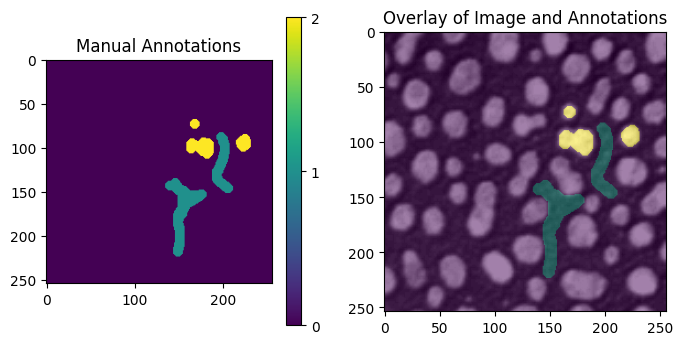

In [6]:
annotations = np.load('data/blobs_segmentation_annotation.npy')

# visualize the manual annotations
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax = ax.ravel()
im0 = ax[0].imshow(annotations)
ax[0].set_title('Manual Annotations')
cbar = plt.colorbar(im0, ax=ax[0], orientation='vertical')
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels([0, 1, 2])

im1 = ax[1].imshow(image, cmap='gray')
ax[1].imshow(annotations, alpha=0.5)
ax[1].set_title('Overlay of Image and Annotations')

plt.show()

### 2.3 Feature extraction
In this subsection, we generate features for each pixel from the original image since we will be classifying pixels in the end.
The idea is to have different values (features) for each pixel to make the classification stronger.  
These values will be obtained by applying different filters to the image.

**TODO**:
1. Implement the two filters from skimage.filters to generate features

In [7]:

# define additional features
blurred_image = filters.gaussian(image, sigma=2) #TODO: Use the filters.gaussian function from the skimage module with sigma=2
edges_image = filters.sobel(blurred_image) #TODO Use the filters.sobel function from the skimage module

# The ravel() function turns a nD image into a 1-D image.
features = [
    image.ravel(),
    blurred_image.ravel(),
    edges_image.ravel()
]

# Transpose the features to have the shape (n_samples, n_features)
features = np.asarray(features).T

# visualize the features as a pandas dataframe
df_features = pd.DataFrame(features)
df_features.columns = ['original', 'blurred', 'edges']
df_features

,original,blurred,edges
0,40.0,0.152516,0.010254
1,32.0,0.138251,0.019776
2,24.0,0.124221,0.017356
3,24.0,0.113924,0.011983
4,16.0,0.109151,0.007384
...,...,...,...
65019,48.0,0.187840,0.000639
65020,48.0,0.187906,0.000220
65021,48.0,0.188119,0.000263
65022,48.0,0.188241,0.000178


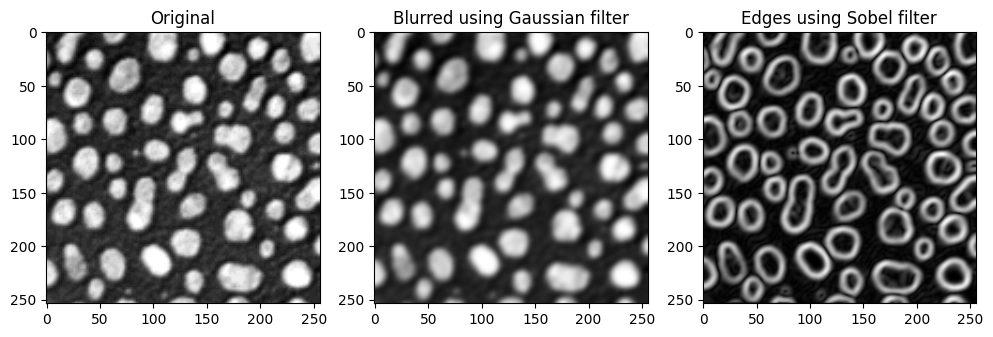

In [8]:

# visualise feature images
fig, axes = plt.subplots(1, 3, figsize=(12,4))

# reshape(image.shape) is the opposite of ravel() here. We just need it for visualization.
axes[0].imshow(df_features["original"].values.reshape(image.shape), cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(df_features["blurred"].values.reshape(image.shape), cmap='gray')
axes[1].set_title('Blurred using Gaussian filter')
axes[2].imshow(df_features["edges"].values.reshape(image.shape), cmap='gray')
axes[2].set_title('Edges using Sobel filter')
plt.show()

#TODO (for fast people) Play around with the sigma parameter of the gaussian blur filter. A larger sigma corresponds to a larger gaussian kernel and thus more blurring. Find a balance so that noise is reduced but edges are still visible.

### 2.4 Format training data
The RandomForestClassifier expects an X array of shape (n_samples, n_features) and a y array of shape (n_features).

In [9]:
X_train = features
y_train = annotations.ravel()

# use only annotated pixels for training
mask = y_train > 0
X_train = X_train[mask]
y_train = y_train[mask]

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

df_train_x_y = pd.DataFrame(X_train)
df_train_x_y['label'] = y_train
# rename columns to feature n
df_train_x_y.columns = [f'feature_{i}' for i in range(3)] + ['label']
df_train_x_y.head()

X_train shape (3252, 3)
y_train shape (3252,)


,feature_0,feature_1,feature_2,label
0,216.0,0.694591,0.105735,2
1,216.0,0.720629,0.092424,2
2,216.0,0.724419,0.090450,2
3,208.0,0.707847,0.099087,2
4,200.0,0.672808,0.113064,2


### 2.5 Train the Random Forest Classifier

**TODO**:
1. Use the scikit-learn's RandomForestClassifier to create and fit the Classifier.

In [10]:
classifier = RandomForestClassifier(max_depth=2, random_state=0) #TODO: initialize a RandomForestClassifier with a max_depth of 2 and a random_state of 0. 
classifier.fit(X_train, y_train) #TODO: Train the classifier with the training data (use the fit method of the classifier)

RandomForestClassifier(max_depth=2, random_state=0)

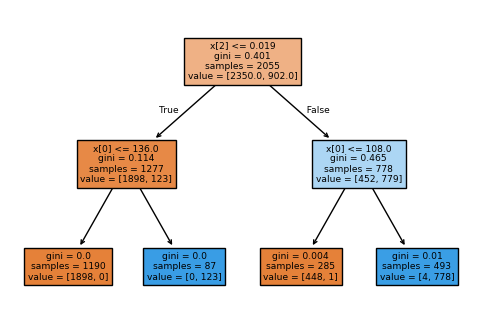

In [11]:
# visualise one of the trees of the "random forest"
from sklearn.tree import plot_tree
plt.figure(figsize=(6, 4))
plot_tree(classifier.estimators_[0], filled=True)
plt.show()

### 2.6 Use the classifier for segmentation

**TODO**:
1. Use the prediciton method of the classifier to predict all pixels of the image

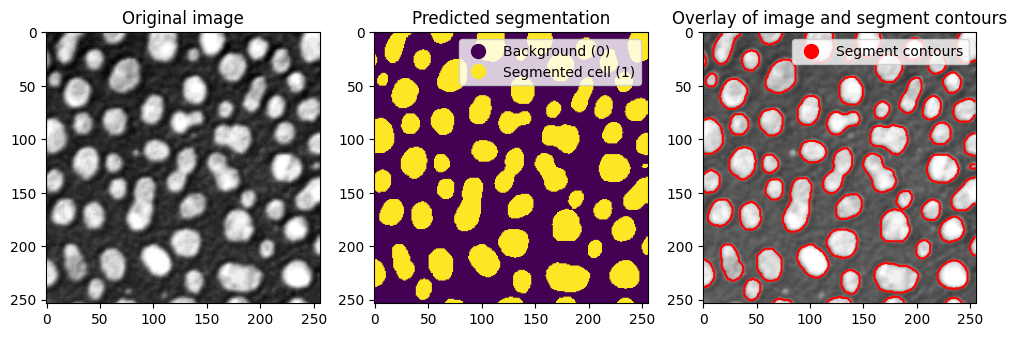

In [12]:
X_predict = features # use all features for all pixels to predict
res = classifier.predict(X_predict) #TODO Use the predict function of the classifier to predict the annotations (cell or background) for the training data
res = res - 1 # we subtract 1 to make background = 0 (this is necessary, since the background is annotated with 1 in the manual annotations)

# visualize the results
res_image = res.reshape(image.shape) # reshape the 1D result array back to the 2D image shape
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.ravel()
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image')

# Display predicted segmentation without specifying cmap (default)
segmentation_plot = ax[1].imshow(res_image)
ax[1].set_title('Predicted segmentation')

# Extract colormap colors
cmap = segmentation_plot.get_cmap()
norm = segmentation_plot.norm  # Normalization of values (0 to 1)
background_color = cmap(norm(0))  # Color for background (0)
segment_color = cmap(norm(1))  # Color for segment (1)

# Add a legend with the correct colors
legend_labels = ['Background (0)', 'Segmented cell (1)']
colors = [background_color, segment_color]  # Extracted colors
patches = [plt.Line2D([0], [0], color=color, marker='o', linestyle='None', markersize=10, label=label)
           for color, label in zip(colors, legend_labels)]
ax[1].legend(handles=patches, loc='upper right')

ax[2].imshow(image, cmap='gray', alpha=0.8)
ax[2].contour(res_image == 1, colors='r')
ax[2].set_title('Overlay of image and segment contours')
## add legend for contours
patches = [plt.Line2D([0], [0], color='r', marker='o', linestyle='None', markersize=10, label='Segment contours')]
ax[2].legend(handles=patches, loc='upper right')

plt.show()

#TODO (for fast people) Play around with the max_depth parameter to see how it affects the classification performance. A larger max_depth corresponds to a more complex model that can capture more details in the data. However, it can also lead to overfitting. Find a balance that works well for this data.

### 2.7 Labeling the segmented objects
This means every object has its own label. Labeling connected components so they have a unique identifier. This is neccessary for the next step 2 - Classification of the objects.

**TODO**: 
1. label the segmented objects

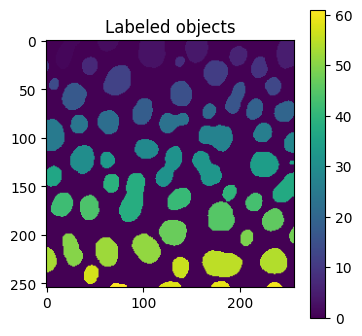

In [13]:
labels = measure.label(res_image) #TODO Use the measure.label function from the skimage module to label the objects in the segmentation
plt.figure(figsize=(4, 4))
plt.imshow(labels)
cbar = plt.colorbar()
plt.title('Labeled objects')
plt.show()

### Compare with non ml methods

- Otsu thresholding  

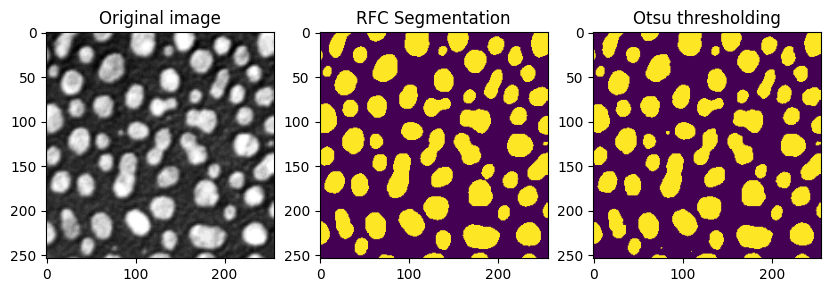

In [14]:
# otsu thresholding
thresh = filters.threshold_otsu(image)
binary = image > thresh
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(res_image)
ax[1].set_title('RFC Segmentation')
ax[2].imshow(binary)
ax[2].set_title('Otsu thresholding')
plt.show()

Otsu thresholding works well here since the example image is greyscale, but tese classical methods get to their limit when images are colourful.

## 3. Classification using RFC

Now we will train a Random Forest classifier (RFC) to classify each segmented and labeled object based on its shape properties.


### 3.1 Annotate data for training
Similar to the segmentation, we need an annotation of the image which can be done manually bu using for example the napari plugin similar to the segmentation part. Here we load a annotation that has already been done.

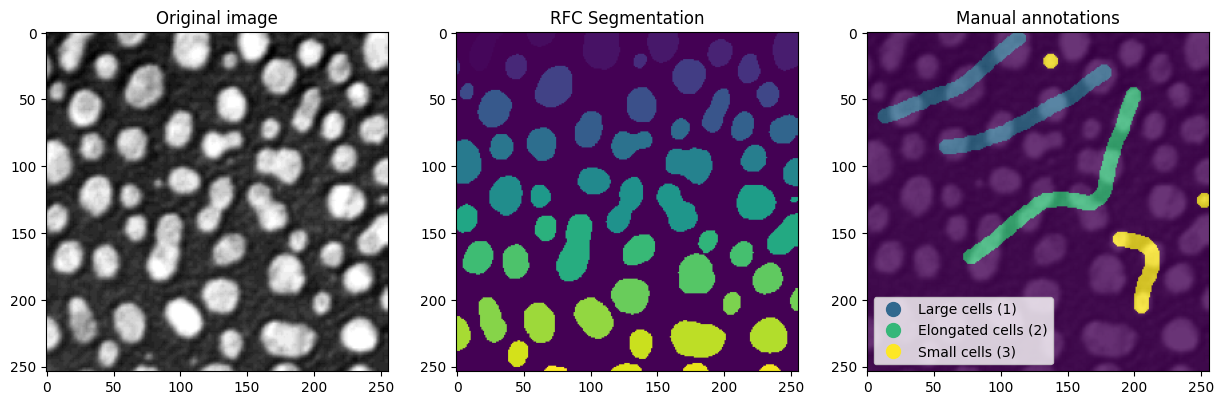

In [15]:
# annotation with classes:
# 1 (blue): large cells
# 2 (green): elongated cells
# 3 (yellow): small cells
class_annotation = np.load('data/blobs_classification_annotation.npy')

# visualize
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(labels)
ax[1].set_title('RFC Segmentation')
# Display the annotation image with transparency
ax[2].imshow(image, cmap='gray')
annotation_plot = ax[2].imshow(class_annotation, alpha=0.8)
ax[2].set_title('Manual annotations')

# Extract colormap and normalization from the annotation plot
cmap = annotation_plot.get_cmap()
norm = annotation_plot.norm

# Define the colors and labels for the legend
legend_labels = ['Large cells (1)', 'Elongated cells (2)', 'Small cells (3)']
colors = [cmap(norm(1)), cmap(norm(2)), cmap(norm(3))]

# Create legend patches
patches = [plt.Line2D([0], [0], color=color, marker='o', linestyle='None', markersize=10, label=label)
           for color, label in zip(colors, legend_labels)]

# Add legend to the lower left corner
ax[2].legend(handles=patches, loc='lower left')
plt.show()

## Feature extraction
The first step to classify objects according to their properties is feature extraction. This is analog to building the feature stack in the segmentation part. The difference here is, we do not extract features for each pixel, but for each segmented object (connected labeled pixels) since we will be classifying the objects in the end.

In [16]:
stats = measure.regionprops(labels, intensity_image=image)

# read out specific measurements as features
label_ids =          np.asarray([s.label for s in stats])
areas =              np.asarray([s.area for s in stats])
minor_axis_lengths = np.asarray([s.minor_axis_length for s in stats])
major_axis_lengths = np.asarray([s.major_axis_length for s in stats])

# compute additional parameters
aspect_ratios = major_axis_lengths / minor_axis_lengths

We also read out the maximum intensity of every labeled object from the ground truth annotation. These values will serve to train the classifier.

In [17]:
annotation_stats = measure.regionprops(labels, intensity_image=class_annotation)

annotated_class = np.asarray([s.intensity_max for s in annotation_stats])

## Data wrangling

To look at the data before it is fed to the training, we visualize it as [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). Note: The rows with `annotated_class=0` correspond to labels that have not been annotated.

In [18]:
data = {
    'label': label_ids,
    'area': areas,
    'minor_axis': minor_axis_lengths,
    'major_axis': major_axis_lengths,
    'aspect_ratio': aspect_ratios,
    'annotated_class': annotated_class
}

table = pd.DataFrame(data)

# show only first 5 rows
table.iloc[:5]

,label,area,minor_axis,major_axis,aspect_ratio,annotated_class
0,1,457.0,17.545233,35.097872,2.000422,0.0
1,2,199.0,12.297796,21.851437,1.776858,0.0
2,3,692.0,29.158946,30.768276,1.055192,1.0
3,4,462.0,23.916582,25.265562,1.056404,0.0
4,5,493.0,20.207694,31.606866,1.564101,0.0


From that table, we extract now a table that only contains the annotated rows/labels.

In [19]:
annotated_table = table[table['annotated_class'] > 0]
annotated_table

,label,area,minor_axis,major_axis,aspect_ratio,annotated_class
2,3,692.0,29.158946,30.768276,1.055192,1.0
7,8,87.0,9.589063,11.552024,1.204708,3.0
10,11,517.0,24.760747,26.637220,1.075784,1.0
11,12,680.0,25.663520,33.892839,1.320662,1.0
14,15,477.0,22.671079,26.826464,1.183290,1.0
15,16,428.0,15.285559,36.467658,2.385759,2.0
16,17,545.0,24.313954,28.613508,1.176835,1.0
17,18,450.0,20.042925,28.666234,1.430242,1.0
21,22,438.0,22.251877,25.125683,1.129149,1.0
26,27,718.0,25.341746,37.450618,1.477823,2.0


As we do not want to use all columns for training, we now select the right columns. It is recommended to write a short convenience function `select_data` for this, because we will reuse it later for prediction.

In [20]:
def select_data(table):
    return np.asarray([
        table['area'],
        table['aspect_ratio']
    ])

training_data = select_data(annotated_table).T
training_data

array([[692.        ,   1.05519164],
       [ 87.        ,   1.20470828],
       [517.        ,   1.07578416],
       [680.        ,   1.32066213],
       [477.        ,   1.18329012],
       [428.        ,   2.38575888],
       [545.        ,   1.17683485],
       [450.        ,   1.43024203],
       [438.        ,   1.12914895],
       [718.        ,   1.4778231 ],
       [645.        ,   2.68651177],
       [680.        ,   1.8986541 ],
       [ 20.        ,   1.42945949],
       [944.        ,   2.44726156],
       [188.        ,   1.29256459],
       [264.        ,   1.17475004],
       [183.        ,   1.31618279]])

We also extract the annotation from that table and call it `ground_truth`.

In [21]:
ground_truth = annotated_table['annotated_class'].tolist()
ground_truth

[1.0,
 3.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 3.0,
 2.0,
 3.0,
 3.0,
 3.0]

## Classifier Training
Next, we can train the [Random Forest Classifer](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). It needs training data and ground truth in the format presented above.

In [22]:
classifier_cells = RandomForestClassifier(max_depth=2, n_estimators=10, random_state=0)
classifier_cells.fit(training_data, ground_truth)

RandomForestClassifier(max_depth=2, n_estimators=10, random_state=0)

## Prediction
To apply a classifier to the whole dataset, or any other dataset, we need to bring the data into the same format as used for training. We can reuse the function `select_data` for that. Furthermore, we need to drop rows from our table where not-a-number ([NaN](https://en.wikipedia.org/wiki/NaN)) values appeared ([read more](tabular_data_wrangling.handling_nan_values)).

In [23]:
table_without_nans = table.dropna(how="any")

all_data = select_data(table_without_nans).T
all_data
# where is alldata inf
np.where(np.isinf(all_data))
all_data[all_data == np.inf] = np.nan

We can then hand over `all_data` to the classifier for prediction.

In [24]:
table_without_nans['predicted_class'] = classifier_cells.predict(all_data)
print(table_without_nans['predicted_class'].tolist())

[2.0, 2.0, 1.0, 1.0, 2.0, 3.0, 3.0, 3.0, 3.0, 2.0, 1.0, 1.0, 3.0, 3.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 3.0, 1.0, 2.0, 3.0, 2.0, 3.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 3.0, 1.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0]


We can then merge the table containing the `predicted_class` column with the original table. In the resulting `table_with_prediction`, we still need to decide how to handle `NaN` values. It is not possible to classify those because measurements are missing. Thus, we replace the class of those with 0 using [`fillna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html).

In [25]:
# merge prediction with original table
table_with_prediction = table.merge(table_without_nans, how='outer', on='label')
# replace not predicted (NaN) with 0
table_with_prediction['predicted_class'] = table_with_prediction['predicted_class'].fillna(0)

table_with_prediction

,label,area_x,minor_axis_x,major_axis_x,aspect_ratio_x,annotated_class_x,area_y,minor_axis_y,major_axis_y,aspect_ratio_y,annotated_class_y,predicted_class
0,1,457.0,17.545233,35.097872,2.000422,0.0,457.0,17.545233,35.097872,2.000422,0.0,2.0
1,2,199.0,12.297796,21.851437,1.776858,0.0,199.0,12.297796,21.851437,1.776858,0.0,2.0
2,3,692.0,29.158946,30.768276,1.055192,1.0,692.0,29.158946,30.768276,1.055192,1.0,1.0
3,4,462.0,23.916582,25.265562,1.056404,0.0,462.0,23.916582,25.265562,1.056404,0.0,1.0
4,5,493.0,20.207694,31.606866,1.564101,0.0,493.0,20.207694,31.606866,1.564101,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
56,57,238.0,15.111637,20.066748,1.327900,0.0,238.0,15.111637,20.066748,1.327900,0.0,3.0
57,58,100.0,5.940553,22.722734,3.825020,0.0,100.0,5.940553,22.722734,3.825020,0.0,2.0
58,59,88.0,6.319101,18.720287,2.962492,0.0,88.0,6.319101,18.720287,2.962492,0.0,2.0
59,60,58.0,5.306313,14.952799,2.817926,0.0,58.0,5.306313,14.952799,2.817926,0.0,2.0


From that table, we can extract the column containing the prediction and use [`replace_intensities`](https://clij.github.io/clij2-docs/reference_replaceIntensities) to generate a `class_image`. The background and objects with NaNs in measurements will have value 0 in that image.

In [26]:
# we add a 0 for the class of background at the beginning
predicted_class = [0] + table_with_prediction['predicted_class'].tolist() 

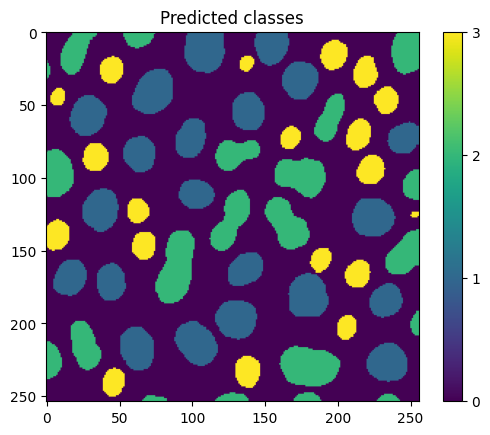

In [27]:
#class_image = replace_intensities(labels, predicted_class)
class_image = labels.copy()
for s in stats:
    class_image[class_image == s.label] = predicted_class[s.label]

plt.imshow(class_image)
cbar = plt.colorbar()
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels([0, 1, 2, 3])
plt.title('Predicted classes')
plt.show()